# Honor 1 Gaussian Mixture Model

Assume response $y$ has following distribution:
$$f(y) = \sum_{k=1}^K \alpha_k \cdot \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{1}{2\sigma^2}(y - \mu_k)^2\right\}$$
where $\alpha_k$, $\mu_k$, $\sigma_k^2$ are the model parameters. Also, $\alpha_k\geqslant 0$ are weights such that $\sum_{k=1}^K\alpha_k =1$. Then we call the model a Gaussian mixture model (GMM).

<br>

Assume there are $K$ Gaussian distributions $N_k = N(\mu_k,\sigma_k^2)$. If we first pick up a random Gaussian distribution $N_k$ with probability $\alpha_k\ (k = 1,\dotsc,K)$, and then sample a random observation $y$ from the Gaussian distribution, then $y$ has the density of the Gaussian mixture model above.

## Clustering

When given unlabeled data $y_1,\dotsc,y_n$, we can do clustering with Gaussian mixture model. Since Gaussian mixture model picks up a random distribution $N_k$ first, we can assume for each data point $y_i$, it is actually sampled from $N_{Z_i}$ (but $Z_i$, the index of the Gaussian distribution, is unknown). 

If we can find the MLE for the model as well as the $Z_i$, then we can cluster the data.

### Latent Variable

Since the Gaussian mixture model first picks up a distribution. We denote it by $Z$, and $\mathbb P(Z = k) = \alpha_k$. The $Z$ is called the latent variable, since it impacts the distribution of the observation $y$ and we do not know beforehand what $Z$ is in clustering.

## EM Algorithm

Assume there are multiple observations $y_1,\dotsc,y_n$ from a Gaussian mixture model and latent variables $z_1,\dotsc,z_n$. Since there is no closed-form solution, we can use iterative algorithms. For example, the EM algorithm.

### Algorithm

Denote $\phi(y|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{1}{2\sigma^2}(y - \mu)^2\right\}$.

First initialize a guess of parameters. Then, repeat the following E-step and M-step until convergence.

E-Step: Compute weights
$$\gamma_{ik} = \frac{\alpha_k \phi(y_i|\mu_k,\sigma_k^2)}{\sum_{j=1}^K \alpha_j \phi(y_i|\mu_j,\sigma_j^2)}
$$

M-Step: Update
$$\sigma_k^2 \leftarrow \frac{\sum_{i=1}^n \gamma_{ik}(y_i - \mu_k)^2}{\sum_{i=1}^n \gamma_{ik}}\quad\quad\mu_k\leftarrow \frac{\sum_{i=1}^n \gamma_{ik}y_i}{\sum_{i=1}^n \gamma_{ik}}
\quad\quad \alpha_k \leftarrow \frac{\sum_{i=1}^n \gamma_{ik}}{n}$$


### Prediction

Given $y$, we can predict the corresponding latent variable $z$:
$$\mathbb P(z=k|y)=\frac{\alpha_k\phi(y|\mu_k,\sigma_k^2)}{\sum_{j=1}^K \alpha_j \phi(y_i|\mu_j,\sigma_j^2)}=\gamma_k. $$

### High Dimensional Version

It can be generalized to high dimensional data $Y\in\mathbb R^{n\times p}$. Denote $\mu_k\in\mathbb R^{p}$ and the variance $\Sigma_k\in\mathcal S_{++}^p$ is positive definite. $\phi(y|\mu_k,\Sigma_k) = \frac{1}{(2\pi)^{\frac n2}|\Sigma_k|^{\frac 12}}\exp\{-\frac 12(y - \mu_k)^T\Sigma_k^{-1}(y-\mu_k)\}\in\mathbb R$. Then, 

E-step: Compute weights $\gamma=[\gamma_1,\dotsc,\gamma_k]^T\in\mathbb R^{K\times n}$
$$\gamma_{ki} = \frac{\alpha_k \phi(y_i|\mu_k,\Sigma_k )}{\sum_{j=1}^K \alpha_j \phi(y_i|\mu_j,\Sigma_j)}
$$

M-step: Let $e = [1,\dotsc,1]^T\in\mathbb R^n$. Update
$$\Sigma_k\leftarrow \frac{(Y - e\mu_k^T){\rm diag}\gamma_k(Y - e\mu_k^T)^T}{\gamma_k^T e}
\quad\quad\mu\leftarrow \frac{\gamma Y}{\gamma e}
\quad\quad \alpha \leftarrow \frac{ \gamma e}{n}$$

In [110]:
import numpy as np
class GMM():
    def __init__(self, mu = None, sigma = None, alpha = None):
        self.mu, self.sigma, self.alpha, self.K = mu, sigma, alpha, 1

    def EM(self, y, K = 1, iter = 20, prob = False):
        """EM Algorithm for GMM. `y` has shape (N, p). `K` is the number of classes."""
        # initialization
        y = y.reshape((y.shape[0], -1))
        N, p = y.shape
        self.K = K
        mu, sigma, alpha = self.mu, self.sigma, self.alpha
        if mu is None:
            mu = np.random.randn(K, p)
        if sigma is None:
            sigma = np.random.randn(K, p, p)
            sigma = np.matmul(sigma, np.transpose(sigma, (0, 2, 1))) # to Hermite
        if alpha is None:
            alpha = np.ones(K) / K
        
        # iteration
        for _ in range(iter):
            # E-step
            self.mu, self.sigma, self.alpha = mu, sigma, alpha
            gamma = self.predict(y, prob = True)

            # M-step
            centery = np.tile(y.reshape((N, 1, p, 1)), (1, K, 1, 1)) - mu.reshape((1, K, p, 1))
            centery = np.transpose(centery.reshape((N, K, p)), (1, 0, 2))
            s = np.sum(gamma, axis = 1)
            sigma = np.matmul(np.transpose(centery, (0, 2, 1)), gamma.reshape((K, N, 1)) * centery)
            sigma /= s.reshape((K, 1, 1))

            mu = gamma @ y / s.reshape((K, 1))

            alpha = s / N

        self.mu, self.sigma, self.alpha = mu, sigma, alpha

        if not prob:
            return np.argmax(gamma, axis = 0)
        return gamma

    def predict(self, y, prob = True):
        """Predict the class of `y` using GMM, P(z|y) = P(y,z) / P(y). Return shape (K, N)."""
        N, p = y.shape
        K = self.K
        mu, sigma, alpha = self.mu, self.sigma, self.alpha
        centery = np.tile(y.reshape((N, 1, p, 1)), (1, K, 1, 1)) - mu.reshape((1, K, p, 1))
        gamma = np.exp(-.5 * np.matmul(np.transpose(centery, (0, 1, 3, 2)), np.linalg.solve(sigma, centery)))
        coeff = (alpha / np.sqrt((2. * np.pi) ** p * np.linalg.det(sigma))).reshape((1, K))
        gamma = (coeff * gamma.reshape((N, K))).T
        gamma /= np.sum(gamma, axis = 0, keepdims = True)

        if not prob:
            return np.argmax(gamma, axis = 0)
        return gamma

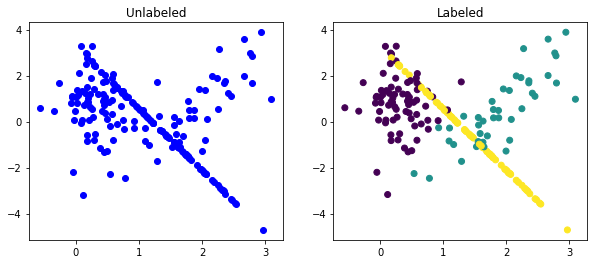

In [2]:
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(9) # nice seeds = 9, 5, 18

# generate some 2D-data
K, p = 3, 2
sigma = np.random.randn(K, p, p)
sigma = np.matmul(sigma, np.transpose(sigma, (0, 2, 1))) # to Hermite
mu = np.random.randn(K, p)
alpha = np.random.random(3)
alpha /= alpha.sum()

N = 200
y, labels = [], []
for i in range(K):
    y.append(np.random.multivariate_normal(mu[i], sigma[i], size = round(alpha[i] * N)))
    labels += [i] * round(alpha[i] * N)
y, labels = np.vstack(y), np.array(labels)
N = y.shape[0]

# random shuffle
shuffle_indices = np.arange(N)
np.random.shuffle(shuffle_indices)
y, labels = y[shuffle_indices], labels.reshape((-1, 1))[shuffle_indices].flatten()

plt.figure(figsize = (10, 4))
for i, title in zip((1, 2), ('Unlabeled', 'Labeled')):
    plt.subplot(1, 2, i)
    plt.scatter(y[:,0], y[:,1], c = labels if i == 2 else 'blue')
    plt.title(title)
plt.show()

Clustering Accuracy = 97.50%


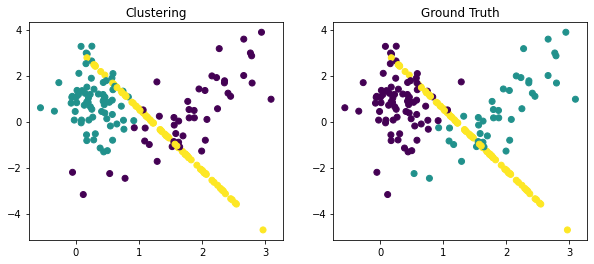

In [53]:
from itertools import permutations
np.random.seed(13) # NOTE: the initialization in GMM matters!
gmm = GMM()
pred_labels = gmm.EM(y, K)

# compute clustering accuracy up to a permutation of labels
best_acc = 0
for perm in permutations(range(K), K):
    perm = np.array(perm)
    best_acc = max(best_acc, (labels == perm[pred_labels]).mean())
print('Clustering Accuracy = %.2f%%'%(100 * best_acc))

plt.figure(figsize = (10, 4))
for i, title, color in zip((1, 2), ('Clustering', 'Ground Truth'), (pred_labels, labels)):
    plt.subplot(1, 2, i)
    plt.scatter(y[:,0], y[:,1], c = color)
    plt.title(title)
plt.show()

Initialization in GMM impacts the result. Bad initialization might lead to NaNs.

 In practice, we can first cluster with K-means, and then initialize $\mu,\sigma^2,\alpha$ with the K-means' result to perform GMM.

In [159]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

np.random.seed(12) # NOTE: the initialization in GMM matters!
data_iris = load_iris()
K = 3

def acc(true_labels, pred_labels):
    """Compute clustering acc up to a permutation"""
    best_acc = 0
    classes = round(np.max(true_labels)) + 1
    for perm in permutations(range(classes), classes):
        perm = np.array(perm)
        best_acc = max(best_acc, (true_labels == perm[pred_labels]).mean())
    return best_acc

gmm = GMM()
pred_labels = gmm.EM(data_iris['data'], K = K, iter = 10)

print('Random GMM Accuracy   = %.2f%%'%(100. * acc(data_iris['target'], pred_labels)))

kmeans_init = KMeans(n_clusters = K).fit(data_iris['data'])
print('KMeans Accuracy       = %.2f%%'%(100. * acc(data_iris['target'], kmeans_init.labels_)))

gmm = GMM(mu = kmeans_init.cluster_centers_, 
        sigma = np.array([np.cov(data_iris['data'][np.where(kmeans_init.labels_ == k)].T) for k in range(K)]))
pred_labels = gmm.EM(data_iris['data'], K = K, iter = 10)
print('KMeans + GMM Accuracy = %.2f%%'%(100. * acc(data_iris['target'], pred_labels)))

Random GMM Accuracy   = 91.33%
KMeans Accuracy       = 89.33%
KMeans + GMM Accuracy = 98.00%
